# Loading and shapping the data

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images

import warnings
warnings.filterwarnings('ignore')

In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import NEpochLogger,callbackWeightLoss
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [4]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset.csv")
x_conso = pd.read_csv(dataset_csv, sep=",",)
x_conso.ds = pd.to_datetime(x_conso.ds)

#drop indices column
x_conso=x_conso.drop(columns=x_conso.columns[0],axis=1)

#Visualize data frame head
x_conso.head(5)

,ds,consumption_France,temperature_France,is_holiday_day
0,2012-12-28 00:00:00,59679.0,8.817600,0.0
1,2012-12-28 00:30:00,58103.0,8.690875,0.0
2,2012-12-28 01:00:00,55354.0,8.564150,0.0
3,2012-12-28 01:30:00,55196.0,8.440525,0.0
4,2012-12-28 02:00:00,54324.0,8.316900,0.0


In [5]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

dict_xconso = {'train': x_conso}

# Normalize input variables
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France']


In [6]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)
type_x = ['conso']
type_cond = ['temperature', 'month']
dataset_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, list_cond=type_cond)
dataset_cond_emb, to_emb_dim = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, list_cond=type_cond, embedding=True)

temperature (1830, 48)
month (1830, 12)
temperature (1830, 48)
month (1830, 12)
3


In [7]:
dataset_cond_emb['train']['x'][2].shape

(1830, 12)

In [8]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_holiday_day'].isna(),'is_holiday_day'] = 0

In [9]:
#Study conso variations as importance factors
slope = np.abs(np.diff(dataset['train']['x'][0]))
#variationMax = np.max(slope, axis=1)
variationMean = np.mean(slope, axis = 1)
#calendar_info['load_variation_max'] = variationMax
calendar_info['load_variation_mean'] = variationMean

In [10]:
#explicit the potential bridge days taken as extended holidays
day_hol = calendar_info[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

calendar_info['potential_bridge_holiday'] = bridges
calendar_info['potential_bridge_holiday'].describe()

count    1830.000000
mean        0.008743
std         0.093121
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: potential_bridge_holiday, dtype: float64

In [11]:
factors = calendar_info.iloc[:,1:5].copy()
columns_x = x_conso.columns
conso_idx = np.argmax(['consumption' in c for c in x_conso.columns])
temp_idx = np.argmax(['temperature' in c for c in x_conso.columns])
dates = np.unique(x_conso['ds'].dt.date)
temperatureMean=np.asarray([np.mean(x_conso[columns_x[temp_idx]].iloc[np.where(x_conso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

factorMatrix = np.c_[factors.values,temperatureMean,variationMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'temperature':'regressor',
    'load_delta_mean' : 'regressor'
}

# Tools pour evaluation

In [12]:
#visualisation d'une représentation 2D dans le notebook
from sklearn.decomposition import PCA
def prez_2D(x_encoded):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');

    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

In [13]:
#visualisation des metrics
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k,, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(1, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(1, 3, 2)
    plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(1, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();

# Setting the options of CVAEs

In [195]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import CVAE.callbacks
import importlib
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
importlib.reload(CVAE.callbacks)
from FeaturesScore.scoring import *

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
z_dim = 4
e_dims=[48,35,24,12]#encoder dim
d_dims=[48,35,24,12]#decoder dim. Dense Blocks in skip connections can make the dimensions bigger when layers are concatenated with the previous one
lr=3e-4
input_dim = dataset['train']['x'][0].shape[1]

In [197]:
epochs = 800
batch_size = 16

# Experimentation on the size of condtions' embeddings

## 1. Without embedding

In [270]:
name_model = 'cvae_test_without_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=dataset_cond['train']['x'][1].shape[1],
                                beta=Beta, is_L2_Loss=False,
                                name=name_model, output=path_out)

L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 12475       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0           encoder[1][0]



--- START TRAINING ---

[257.96555 595.4761  478.9809  314.21674]
7.1615710677083335
              is_weekday  weekday     month  is_holiday_day  temperature
score model     0.589133  0.15842  0.611898        0.061818      0.66911
random model    0.488685  0.13750  0.082569        0.018182     -0.42030
0 Epochs ...  - loss: 27.6759 - decoder_loss: 26.9318 - decoder_for_kl_loss: 0.7441 - val_loss: 20.3506 - val_decoder_loss: 20.1027 - val_decoder_for_kl_loss: 0.2479 val_loss 20.350581601669226 ... lambda Loss 1.0
[  66.01586 1600.5513    91.97468   72.93914]
9.901872052083329
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.924570  0.387935  0.285057        0.134545     0.230594
random model    0.466915  0.141922  0.079930        0.014545    -0.408362
100 Epochs ...  - loss: 5.3213 - decoder_loss: 3.3961 - decoder_for_kl_loss: 1.9253 - val_loss: 5.4333 - val_decoder_loss: 3.4392 - val_decoder_for_kl_loss: 1.9941 val_loss 5.43327705977393 ... 

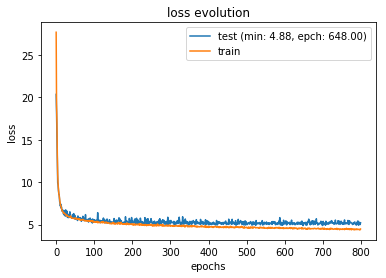

In [271]:
out_batch = NEpochLogger(x_train_data=dataset_cond['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond.main_train(dataset_cond, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [272]:
x_input = dataset_cond['train']['x']

input_encoder = x_input

x_encoded, variance = model_CVAE_cond.encoder.predict(input_encoder)
variance = np.exp(variance)

x_hat = model_CVAE_cond.cvae.predict(x=input_encoder)[0]

In [273]:
stats.describe(np.exp(variance))[1:3]

((array([2.617943 , 1.002825 , 2.6813364, 2.645558 ], dtype=float32),
  array([2.7219596, 1.422143 , 2.708989 , 2.7194493], dtype=float32)),
 array([2.6892743, 1.0565728, 2.6981084, 2.6797998], dtype=float32))

mean_absolute_error :  2.746122749297242
mean_squared_error :  0.4766104629881487
Mutual Information Gap : 0.01


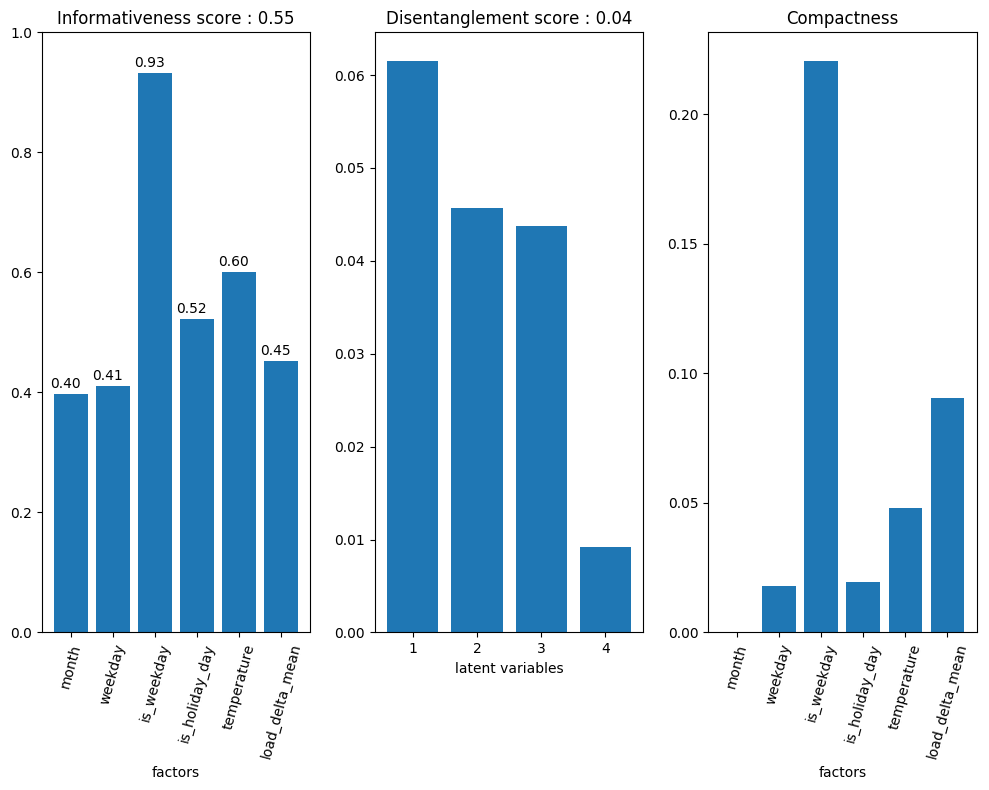

In [274]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

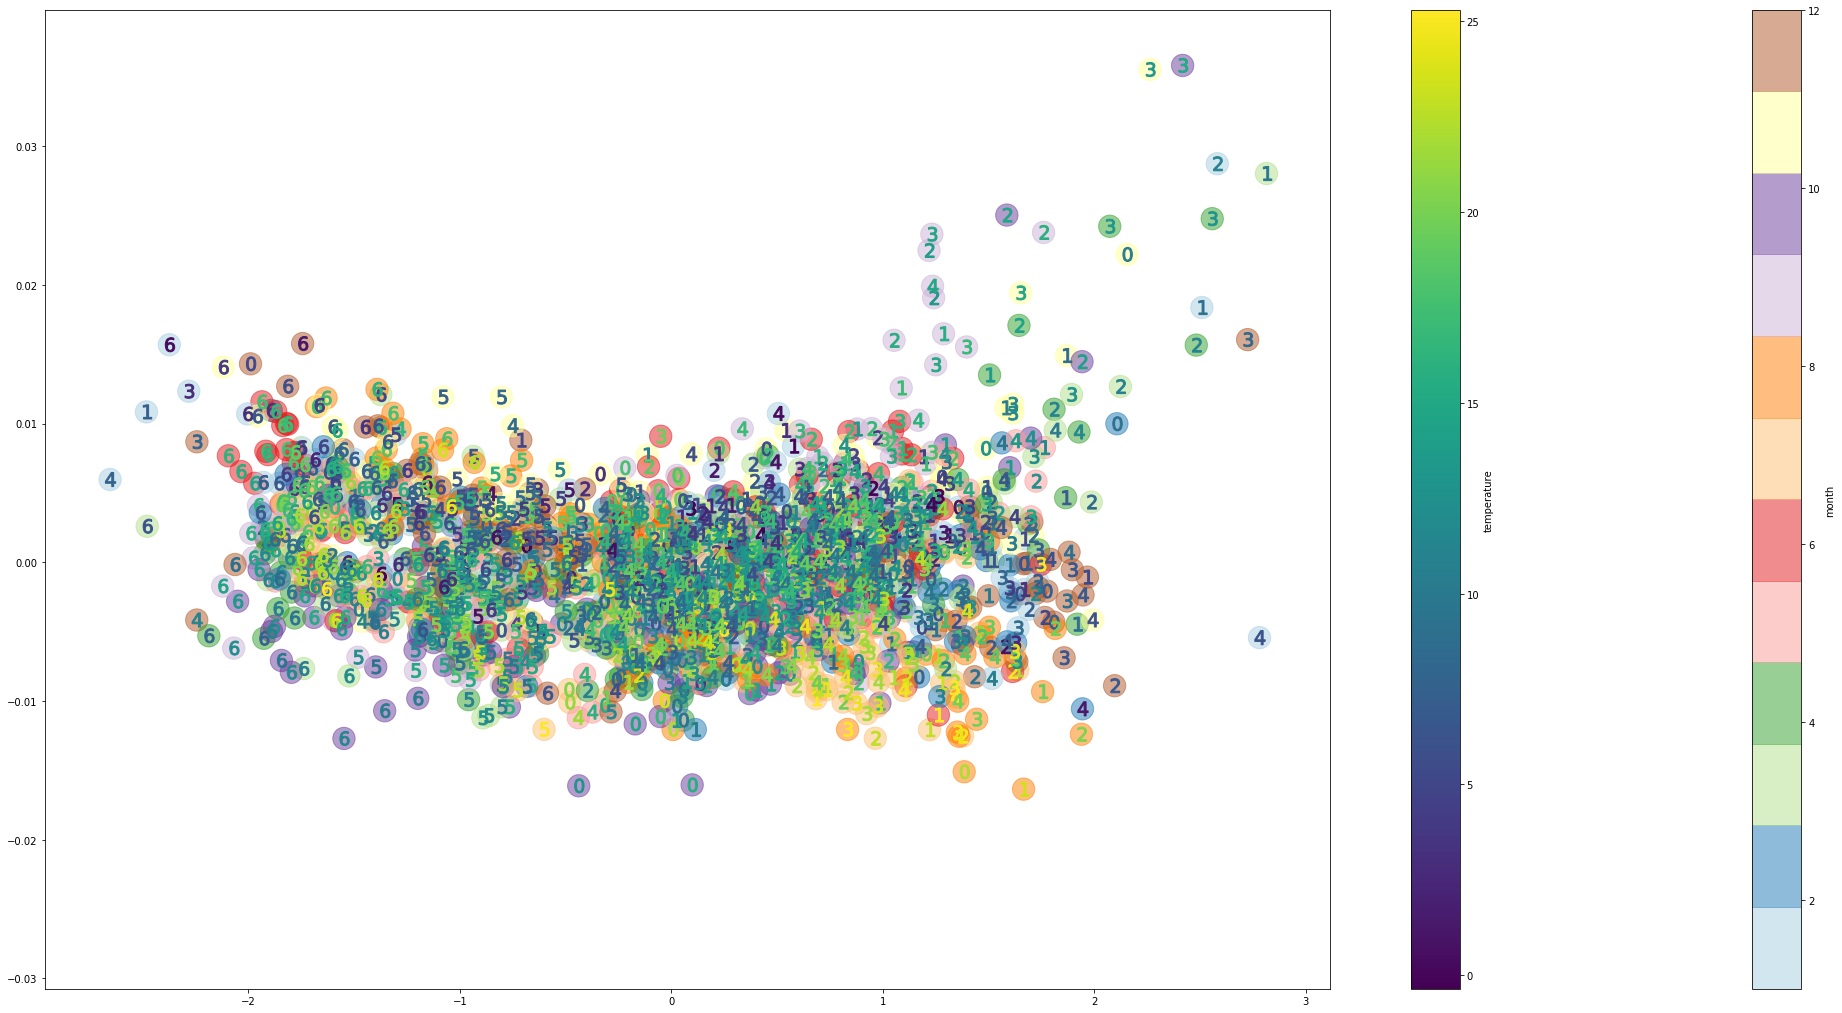

In [203]:
prez_2D(x_encoded)

In [204]:
to_emb_dim

[48, 12]

## Test with embedding

In [205]:
#embeddings conditions
emb_dims=[[12,4],[6,3]]
emb_to_z_dim=[6,z_dim]

In [206]:
name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

4
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
emb_dense_0_0 (Dense)           (None, 12)           588         emb_input_0[0][0]                
__________________________________________________________________________________________________
emb_dense_1_0 (Dense)           (None, 6)            78          emb_input_1[0][0]                
__________________________________________________________________________________________________
emb_dens



--- START TRAINING ---

emb_input_0
emb_input_1
[ 742.00116 1356.5457   165.688    836.3898 ]
5.8840573281249995
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.788527  0.329618  0.449426        0.072727     0.778688
random model    0.456032  0.131720  0.085249        0.054545    -0.443809
0 Epochs ...  - loss: 38.0441 - decoder_loss: 37.5531 - decoder_for_kl_loss: 0.4911 - val_loss: 29.9951 - val_decoder_loss: 28.9178 - val_decoder_for_kl_loss: 1.0773 val_loss 29.995052306378476 ... lambda Loss 1.0
emb_input_0
emb_input_1
[ 121.190605 1260.1394     43.916817   49.52783 ]
10.233072192708335
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.954895  0.454915  0.298648        0.170909     0.284017
random model    0.472540  0.139347  0.080872        0.029091    -0.435927
100 Epochs ...  - loss: 6.8637 - decoder_loss: 4.7321 - decoder_for_kl_loss: 2.1316 - val_loss: 6.3471 - val_decoder_loss: 4.4379 - va

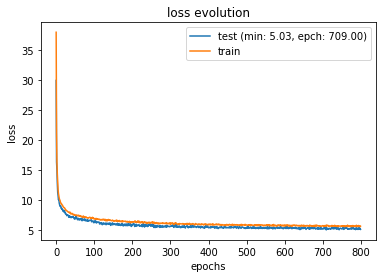

In [207]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [208]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


Mutual Information Gap : 0.01


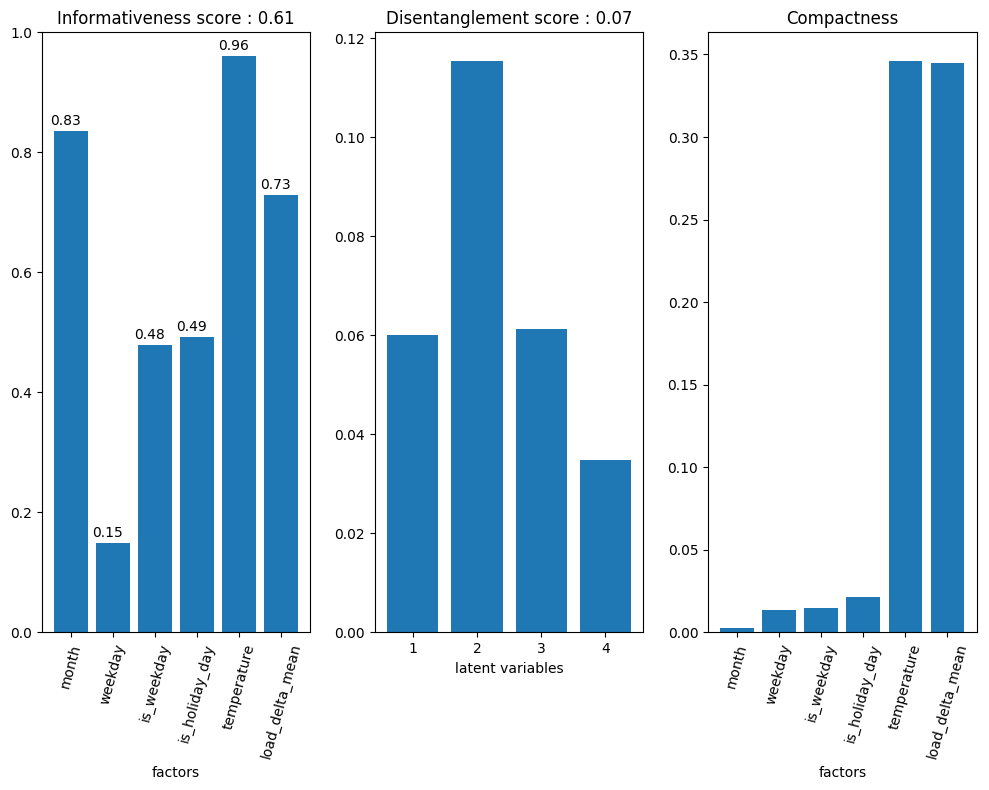

In [209]:
model_eval, importanceMatrix =evaluateLatentCode(emb_outputs, factorMatrix, factorDesc)
display_metrics(model_eval, emb_outputs.shape[1], factorDesc)

mean_absolute_error :  3.063091053210484
mean_squared_error :  0.5368339906773928
Mutual Information Gap : 0.13


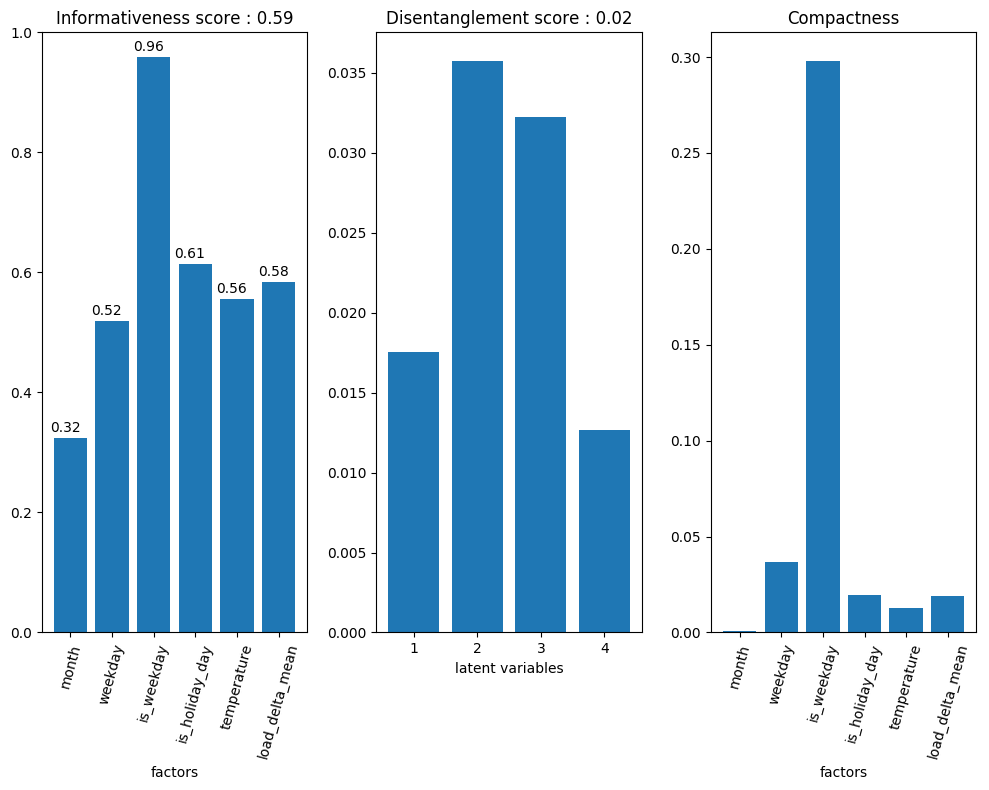

In [210]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

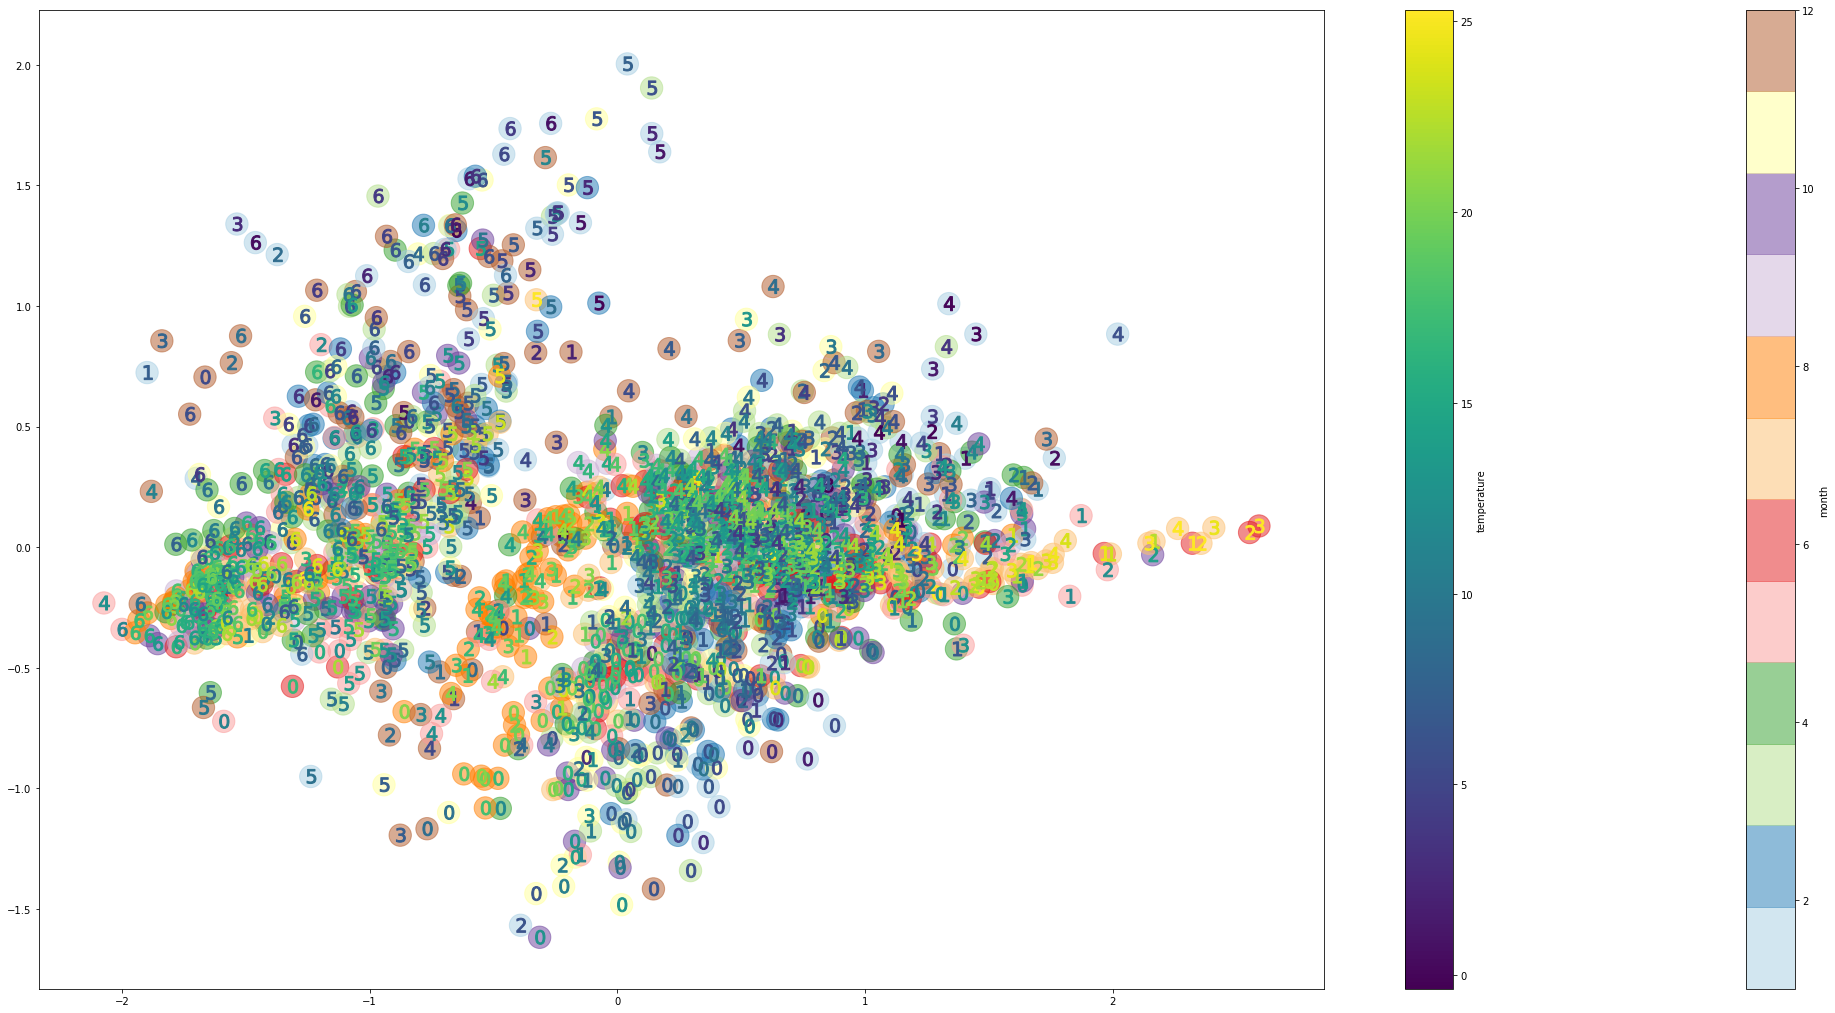

In [211]:
prez_2D(x_encoded)

### Variation de la taille des couches

In [223]:
#just temperature embedding
emb_dims=[[16,8]]
emb_to_z_dim=[8,z_dim]
to_emb_dim_spec = [48]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=12,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim_spec, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb_input_0 (InputLayer)     (None, 48)                0         
_________________________________________________________________
emb_dense_0_0 (Dense)        (None, 16)                784       
_________________________________________________________________
emb_dense_0_1 (Dense)        (None, 8)                 136       
_________________________________________________________________
activation_80 (Activation)   (None, 8)                 0         
_________________________________________________________________
emb_dense_last_reduction_0 ( (None, 8)                 72        
_________________________________________________________________
batch_normalization_42 (Batc (None, 8)                 32        
_________________________________________________________________
activation_81 (Activation)   (None, 8)                 0         
_______

In [224]:
dataset_cond_pre = dataset_cond_emb.copy()
dataset_cond_pre['train']['x'] = [dataset_cond_emb['train']['x'][0],dataset_cond_emb['train']['x'][2],dataset_cond_emb['train']['x'][1]]
dataset_cond_pre['train']['x'][2].shape

(1830, 48)



--- START TRAINING ---

emb_input_0
[ 446.80176  965.90015  656.7317  1095.5325 ]
5.38725303125
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.839406  0.316074  0.896347        0.167273     0.800055
random model    0.485604  0.156844  0.082554        0.032727    -0.461589
0 Epochs ...  - loss: 37.5851 - decoder_loss: 37.1520 - decoder_for_kl_loss: 0.4331 - val_loss: 30.6221 - val_decoder_loss: 29.6678 - val_decoder_for_kl_loss: 0.9544 val_loss 30.622132452459283 ... lambda Loss 1.0
emb_input_0
[  69.82342    93.97709    59.278378 1503.0154  ]
10.649394942708334
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.936994  0.396137  0.386219        0.156364     0.194369
random model    0.480506  0.151774  0.089567        0.007273    -0.426977
100 Epochs ...  - loss: 6.0866 - decoder_loss: 4.1576 - decoder_for_kl_loss: 1.9290 - val_loss: 5.6571 - val_decoder_loss: 3.7500 - val_decoder_for_kl_loss: 1.9071

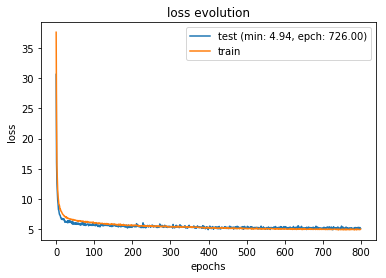

In [225]:
out_batch = NEpochLogger(x_train_data=dataset_cond_pre['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_pre, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [226]:
dataset_cond_pre['train']['x'][2].shape

(1830, 48)

In [227]:
x_input = dataset_cond_pre['train']['x']
emb_inputs=x_input[2:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset_cond_pre['train']['x'][0],np.concatenate([dataset_cond_pre['train']['x'][1], emb_outputs], axis=1)]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


Mutual Information Gap : 0.03


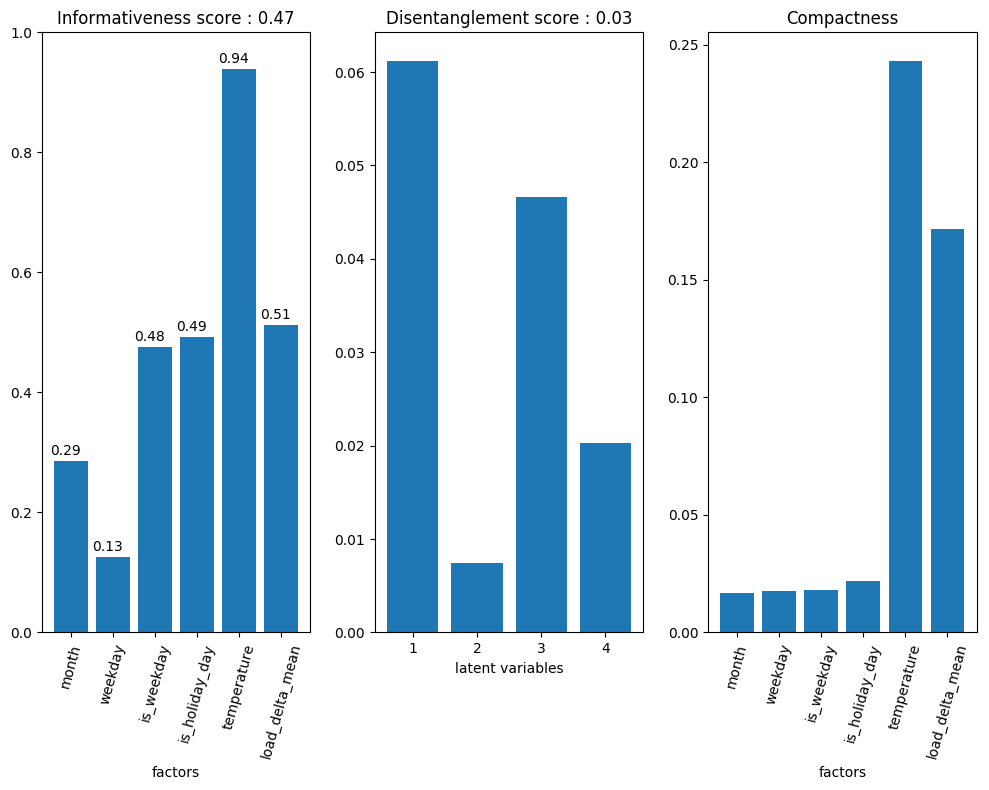

In [228]:
model_eval, importanceMatrix =evaluateLatentCode(emb_outputs, factorMatrix, factorDesc)
display_metrics(model_eval, emb_outputs.shape[1], factorDesc)

mean_absolute_error :  2.83769192051448
mean_squared_error :  0.5008671323696507
Mutual Information Gap : 0.20


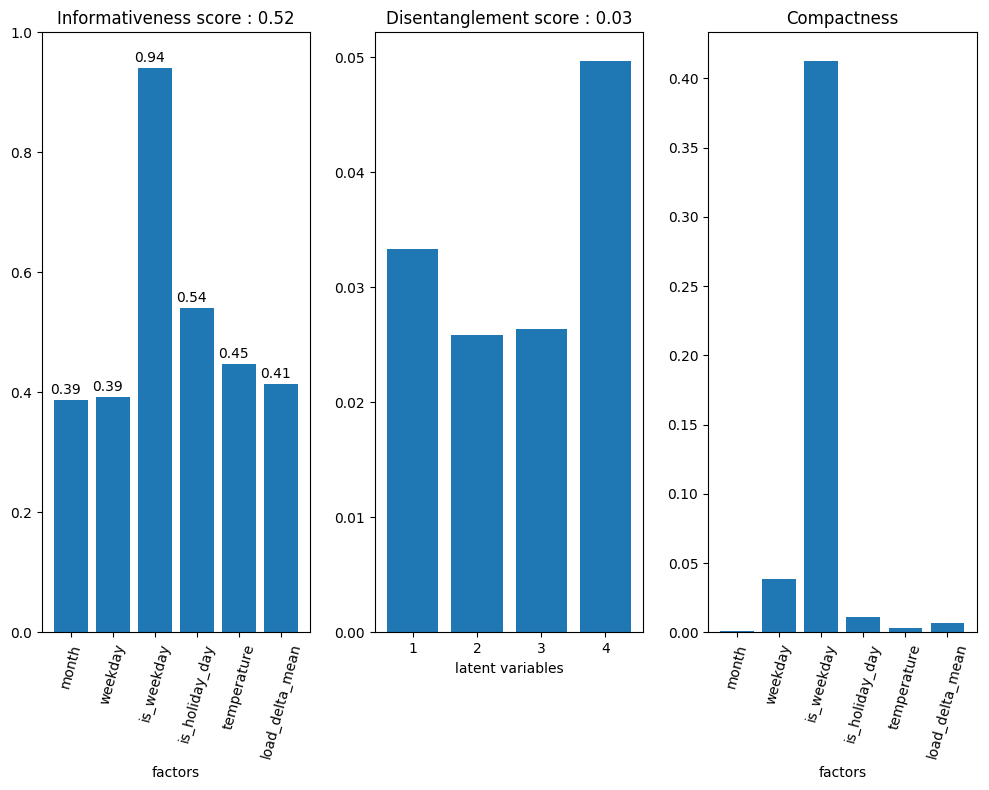

In [229]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

In [230]:
dataset_cond_pre = dataset_cond_emb.copy()
dataset_cond_pre['train']['x'] = [dataset_cond_emb['train']['x'][0],dataset_cond_emb['train']['x'][2],dataset_cond_emb['train']['x'][1]]
dataset_cond_pre['train']['x'][2].shape

(1830, 12)

In [231]:
#just month embedding
emb_dims=[[9,6]]
emb_to_z_dim=[4]
to_emb_dim_spec=[12]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=48,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim_spec, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

52
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb_input_0 (InputLayer)     (None, 12)                0         
_________________________________________________________________
emb_dense_0_0 (Dense)        (None, 9)                 117       
_________________________________________________________________
emb_dense_0_1 (Dense)        (None, 6)                 60        
_________________________________________________________________
activation_83 (Activation)   (None, 6)                 0         
_________________________________________________________________
emb_dense_last_reduction_0 ( (None, 4)                 28        
_________________________________________________________________
batch_normalization_44 (Batc (None, 4)                 16        
_________________________________________________________________
activation_84 (Activation)   (None, 4)                 0         
Total p



--- START TRAINING ---

emb_input_0
[207.66539 251.09073 354.05084 403.8423 ]
3.25012525
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.664205  0.191712  0.417422        0.076364     0.900540
random model    0.472753  0.158425  0.075711        0.021818    -0.411885
0 Epochs ...  - loss: 29.8079 - decoder_loss: 28.9426 - decoder_for_kl_loss: 0.8653 - val_loss: 20.0287 - val_decoder_loss: 19.8296 - val_decoder_for_kl_loss: 0.1991 val_loss 20.028696695963543 ... lambda Loss 1.0
emb_input_0
[  65.40498    78.139496   78.84322  1590.9796  ]
9.032735947916667
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.902301  0.344723  0.254103        0.167273     0.400696
random model    0.485191  0.153601  0.089583        0.036364    -0.459686
100 Epochs ...  - loss: 5.6618 - decoder_loss: 3.6741 - decoder_for_kl_loss: 1.9878 - val_loss: 5.7125 - val_decoder_loss: 3.7577 - val_decoder_for_kl_loss: 1.9548 val_los

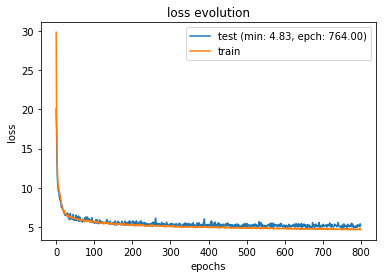

In [232]:
out_batch = NEpochLogger(x_train_data=dataset_cond_pre['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_pre, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [233]:
x_input = dataset_cond_pre['train']['x']
emb_inputs=x_input[2:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset_cond_pre['train']['x'][0],np.concatenate([dataset_cond_pre['train']['x'][1], emb_outputs], axis=1)]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  2.7623942986723815
mean_squared_error :  0.4814591427637439
Mutual Information Gap : 0.03


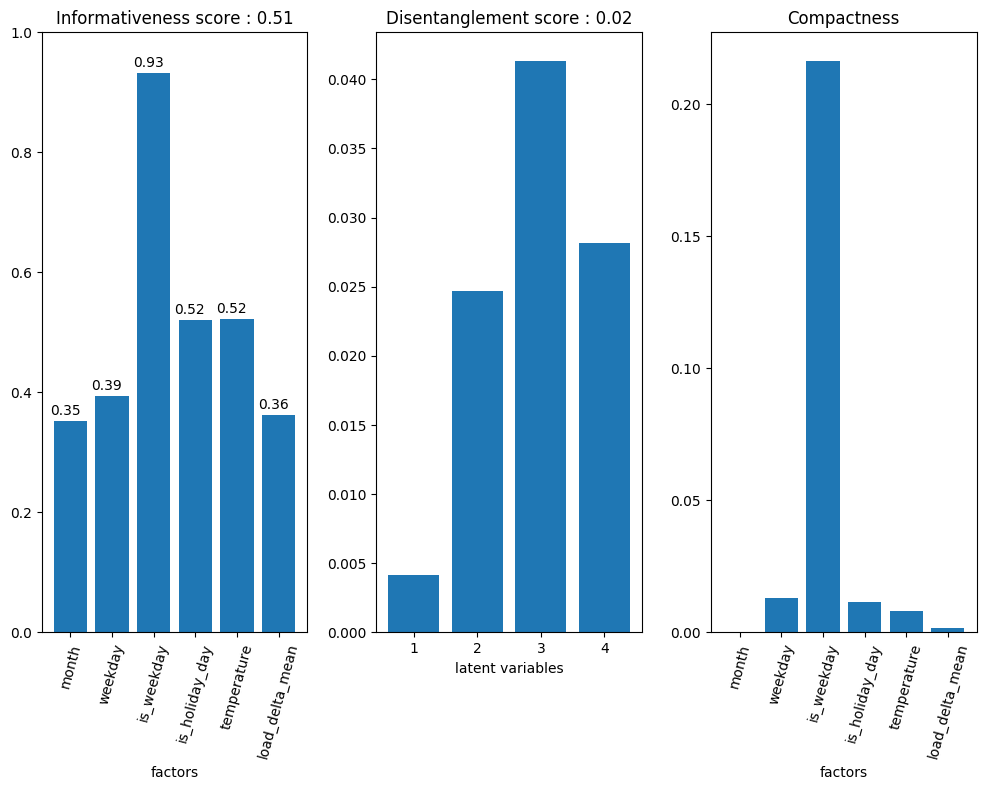

In [234]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

Mutual Information Gap : 0.02


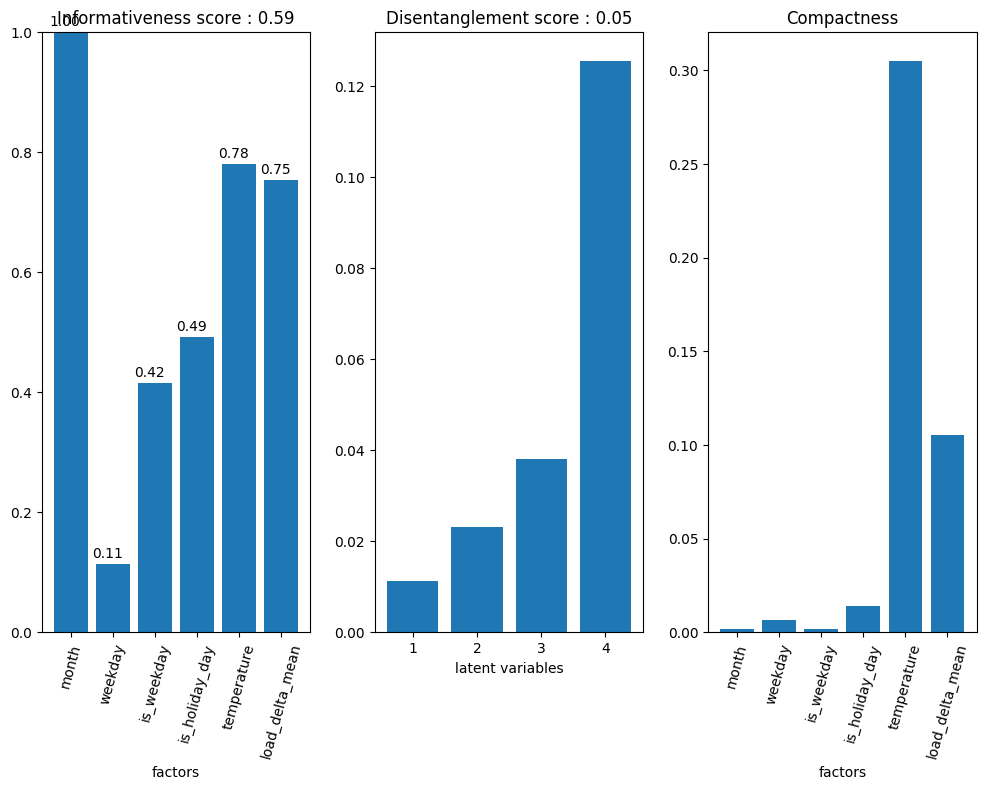

In [235]:
model_eval, importanceMatrix =evaluateLatentCode(emb_outputs, factorMatrix, factorDesc)
display_metrics(model_eval, emb_outputs.shape[1], factorDesc)

In [236]:
#Both variation
def set_layer_dim(input_dim, output_dim, n_layers):
    hidden = np.linspace(start=output_dim, stop=input_dim, num=n_layers+2,dtype=int)
    return [z for z in hidden[1:n_layers+1][::-1]]
    
print(np.logspace(2,6,num=5,base=2, dtype=int))
print(np.logspace(2,4,num=5,base=2, dtype=int))

[ 4  8 16 32 64]
[ 4  5  8 11 16]


In [237]:
#gradual growth of embedding size
emb_to_z_dim=[8,4]
emb_dims=[set_layer_dim(48, 5, 2),set_layer_dim(12, 3, 2)]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

4
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
emb_dense_0_0 (Dense)           (None, 33)           1617        emb_input_0[0][0]                
__________________________________________________________________________________________________
emb_dense_1_0 (Dense)           (None, 9)            117         emb_input_1[0][0]                
__________________________________________________________________________________________________
emb_dens



--- START TRAINING ---

emb_input_0
emb_input_1
[ 474.18985 1403.4174  1615.8208  2005.9736 ]
3.780204682291666
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.821646  0.307698  0.385042        0.109091     0.895249
random model    0.486113  0.123559  0.084030        0.025455    -0.446528
0 Epochs ...  - loss: 32.7313 - decoder_loss: 31.5141 - decoder_for_kl_loss: 1.2172 - val_loss: 20.0353 - val_decoder_loss: 17.2716 - val_decoder_for_kl_loss: 2.7637 val_loss 20.035294329533812 ... lambda Loss 1.0
emb_input_0
emb_input_1
[ 116.10441    63.440063  615.4176   1405.6808  ]
8.202671109374997
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.965908  0.489150  0.304316        0.232727     0.509585
random model    0.482762  0.122372  0.069522        0.018182    -0.433196
100 Epochs ...  - loss: 6.4363 - decoder_loss: 4.1864 - decoder_for_kl_loss: 2.2499 - val_loss: 5.9685 - val_decoder_loss: 3.8864 - val_

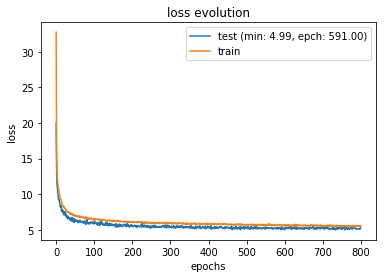

In [238]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [239]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


Mutual Information Gap : 0.00


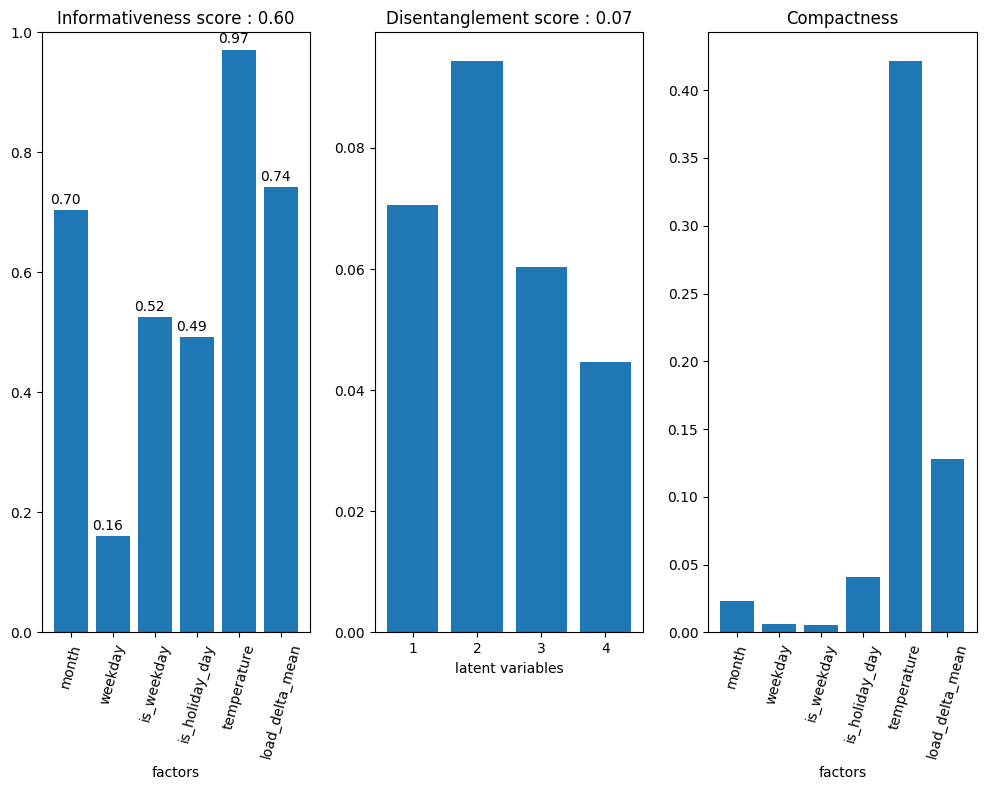

In [240]:
model_eval, importanceMatrix =evaluateLatentCode(emb_outputs, factorMatrix, factorDesc)
display_metrics(model_eval, emb_outputs.shape[1], factorDesc)

mean_absolute_error :  2.9936294101223884
mean_squared_error :  0.5250182859617946
Mutual Information Gap : 0.16


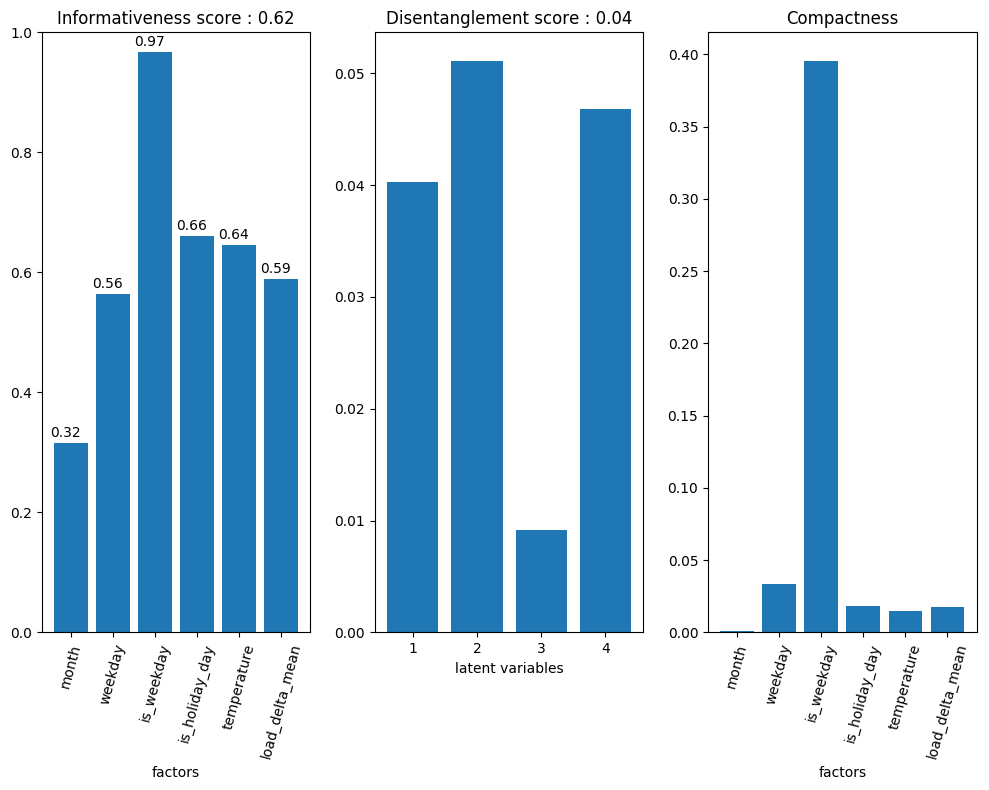

In [241]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

Mutual Information Gap : 0.01


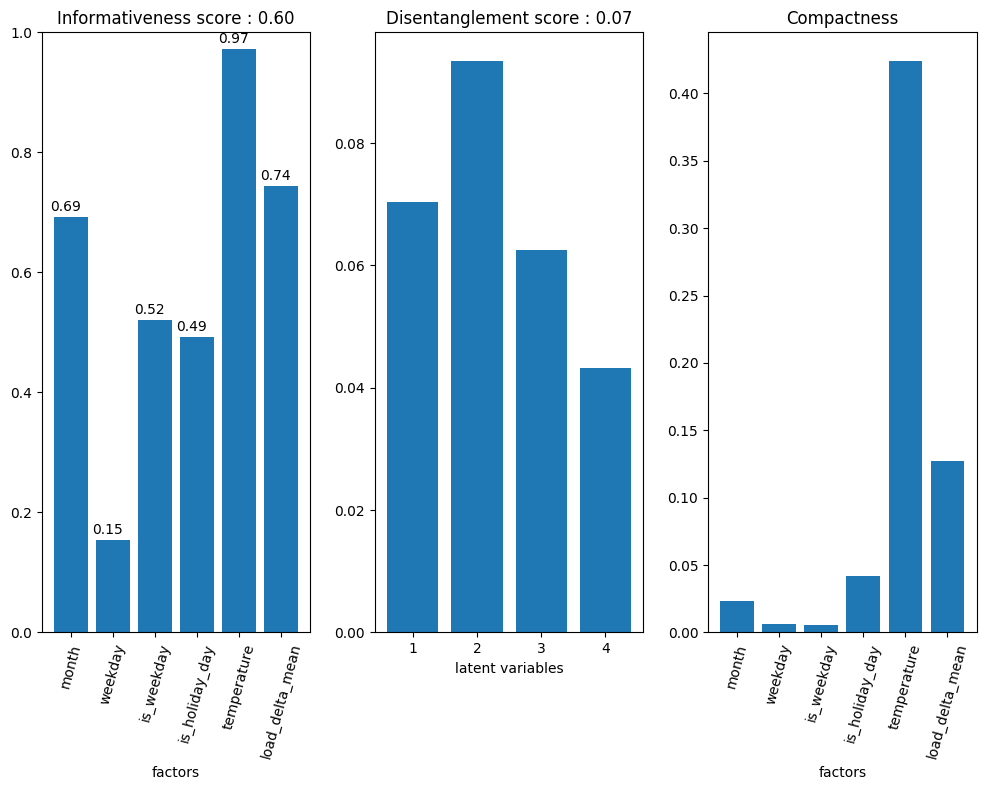

In [242]:
model_eval, importanceMatrix =evaluateLatentCode(emb_outputs, factorMatrix, factorDesc)
display_metrics(model_eval, emb_outputs.shape[1], factorDesc)

In [243]:
#gradual growth of embedding size
emb_to_z_dim=[16,8]
emb_dims=[set_layer_dim(48, 10, 2),set_layer_dim(12, 6, 2)]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

8
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
emb_dense_0_0 (Dense)           (None, 35)           1715        emb_input_0[0][0]                
__________________________________________________________________________________________________
emb_dense_1_0 (Dense)           (None, 10)           130         emb_input_1[0][0]                
__________________________________________________________________________________________________
emb_dens



--- START TRAINING ---

emb_input_0
emb_input_1
[1811.4137 1329.3446  383.8955 1075.9362]
4.727166515624999
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.838956  0.325740  0.360716        0.130909     0.865437
random model    0.440440  0.147417  0.106928        0.018182    -0.427636
0 Epochs ...  - loss: 32.4022 - decoder_loss: 31.5421 - decoder_for_kl_loss: 0.8601 - val_loss: 20.0030 - val_decoder_loss: 17.8512 - val_decoder_for_kl_loss: 2.1517 val_loss 20.002957119967768 ... lambda Loss 1.0
emb_input_0
emb_input_1
[1359.3342     89.623405   67.27273   448.60944 ]
8.108540697916666
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.964561  0.509442  0.327511        0.247273     0.510317
random model    0.501933  0.149308  0.079307        0.021818    -0.432434
100 Epochs ...  - loss: 6.2756 - decoder_loss: 4.0763 - decoder_for_kl_loss: 2.1993 - val_loss: 5.8899 - val_decoder_loss: 3.9433 - val_deco

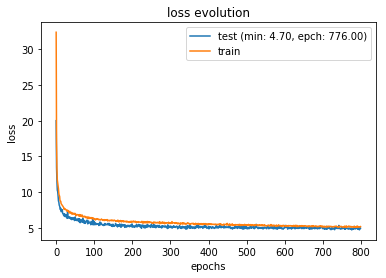

In [244]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [245]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  2.8836523449666287
mean_squared_error :  0.5042241064753868
Mutual Information Gap : 0.06


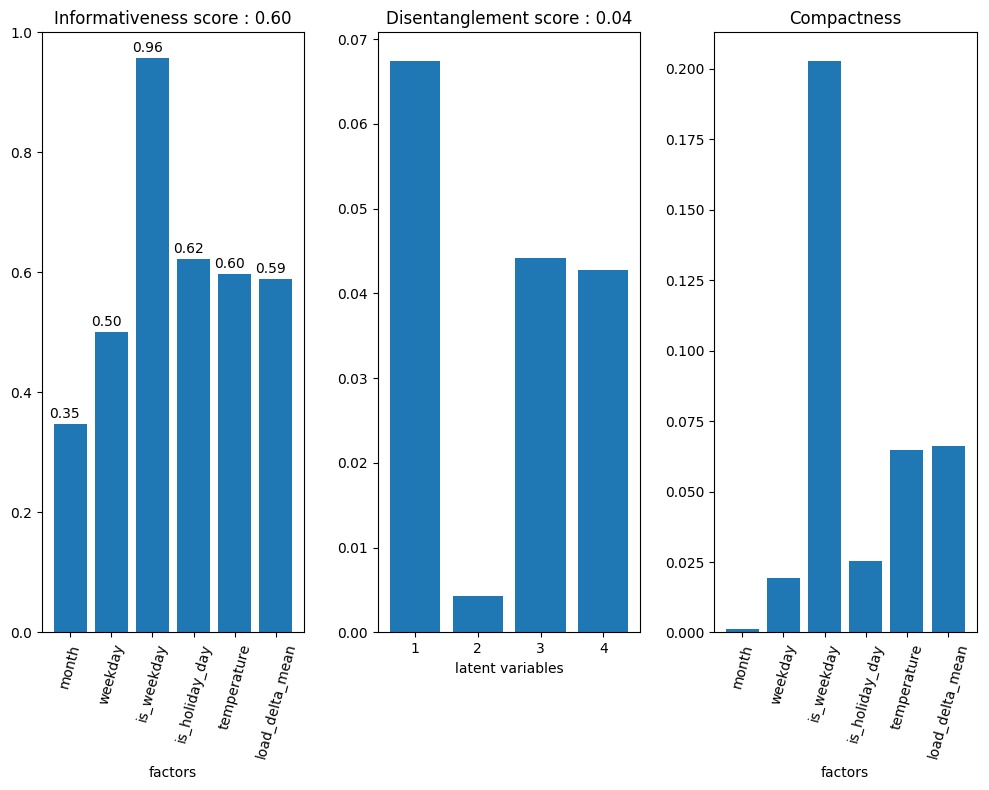

In [246]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

Mutual Information Gap : 0.01


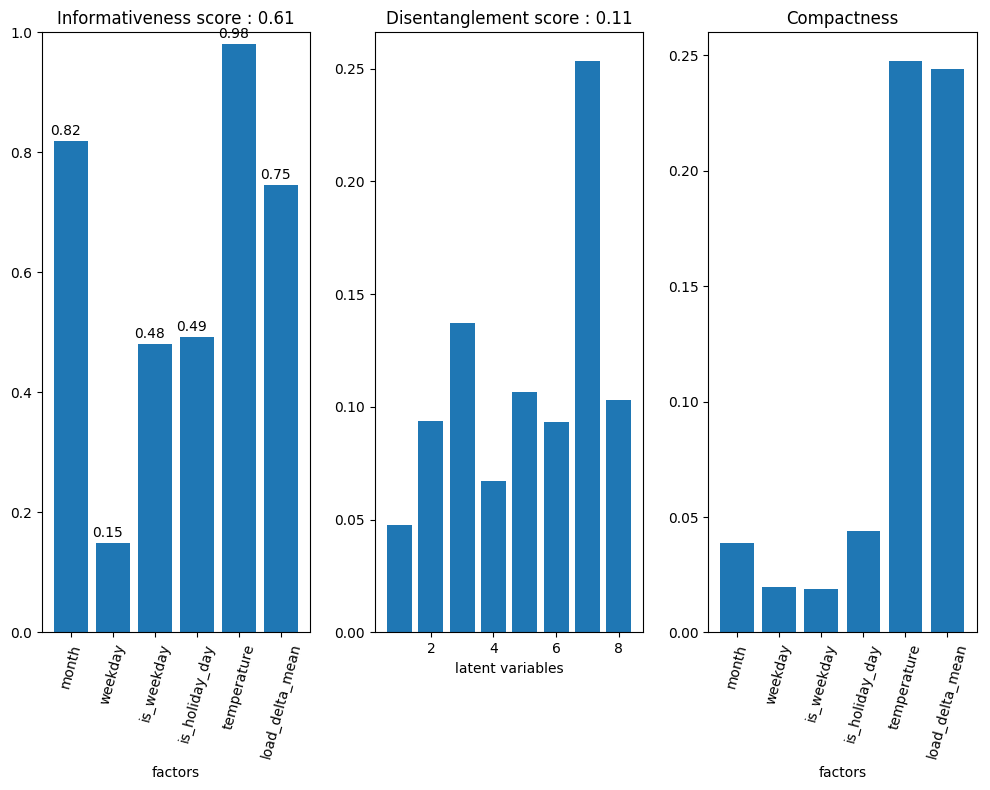

In [247]:
model_eval, importanceMatrix =evaluateLatentCode(emb_outputs, factorMatrix, factorDesc)
display_metrics(model_eval, emb_outputs.shape[1], factorDesc)

In [248]:
#gradual growth of embedding size
emb_to_z_dim=[32,16]
emb_dims=[set_layer_dim(48, 24, 2),set_layer_dim(12, 8, 2)]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

16
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
emb_dense_0_0 (Dense)           (None, 40)           1960        emb_input_0[0][0]                
__________________________________________________________________________________________________
emb_dense_1_0 (Dense)           (None, 10)           130         emb_input_1[0][0]                
__________________________________________________________________________________________________
emb_den



--- START TRAINING ---

emb_input_0
emb_input_1
[ 813.7036   530.868    210.31244 1201.614  ]
5.071582364583332
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.735660  0.253659  0.424851        0.050909     0.839041
random model    0.481378  0.141995  0.082461        0.032727    -0.412620
0 Epochs ...  - loss: 31.3919 - decoder_loss: 30.7792 - decoder_for_kl_loss: 0.6127 - val_loss: 20.5274 - val_decoder_loss: 19.6103 - val_decoder_for_kl_loss: 0.9171 val_loss 20.527395196299736 ... lambda Loss 1.0
emb_input_0
emb_input_1
[1418.3774     63.377995   95.50013    94.41    ]
9.711777203125
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.936071  0.409916  0.325236        0.167273     0.291761
random model    0.473841  0.158548  0.088672        0.032727    -0.414923
100 Epochs ...  - loss: 6.1858 - decoder_loss: 4.1761 - decoder_for_kl_loss: 2.0097 - val_loss: 5.6894 - val_decoder_loss: 3.8719 - val_dec

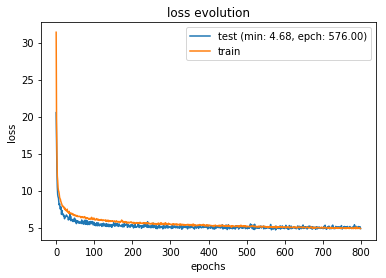

In [249]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [250]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


mean_absolute_error :  2.800804154660124
mean_squared_error :  0.4896064629120216
Mutual Information Gap : 0.22


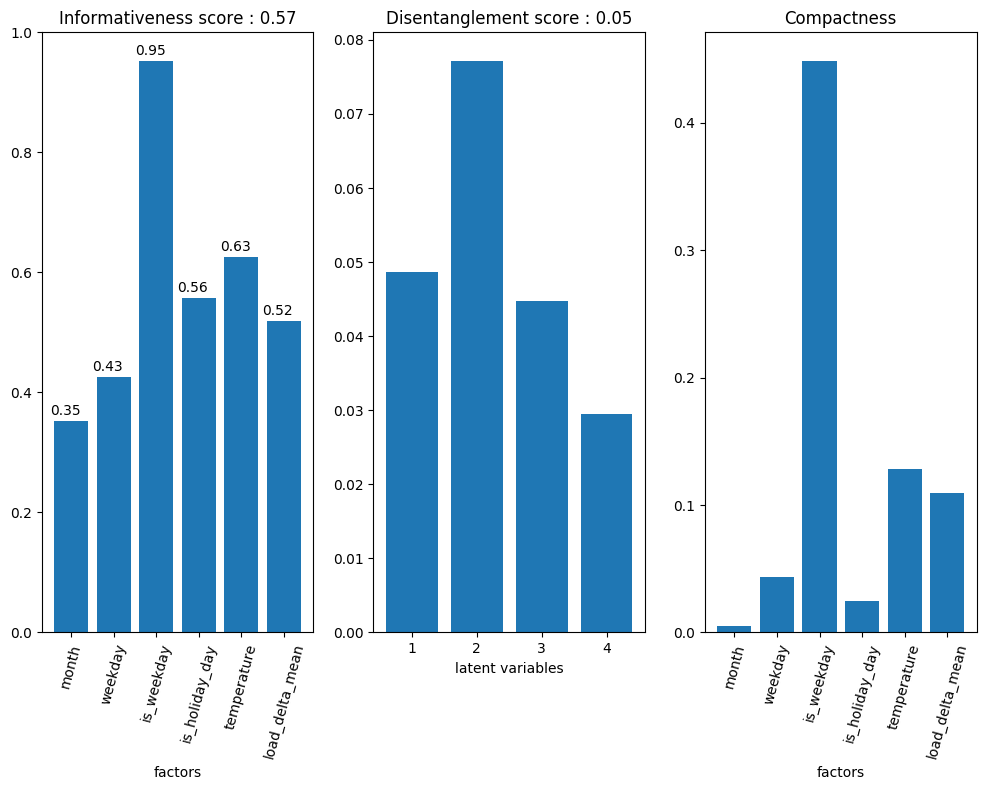

In [251]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(model_eval, z_dim, factorDesc)

Mutual Information Gap : 0.02


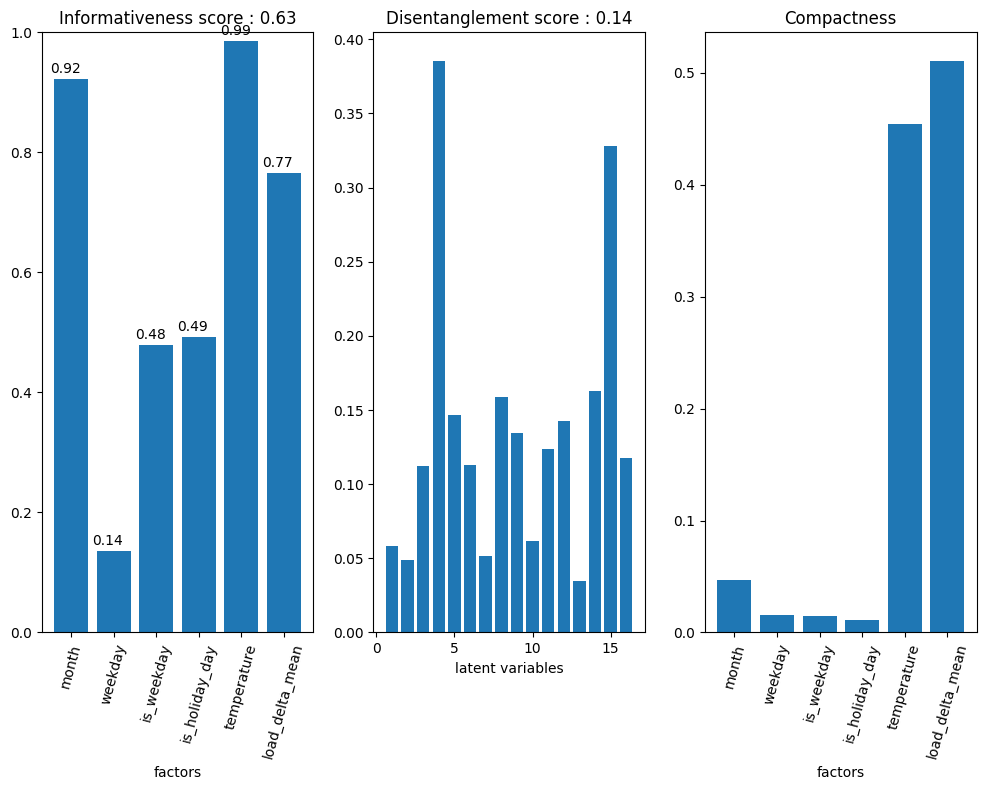

In [252]:
model_eval, importanceMatrix =evaluateLatentCode(emb_outputs, factorMatrix, factorDesc)
display_metrics(model_eval, emb_outputs.shape[1], factorDesc)

In [253]:
#gradual growth of embedding size
emb_to_z_dim=[4,2]
emb_dims=[set_layer_dim(48, 3, 2),set_layer_dim(12, 1, 2)]

name_model = 'cvae_test_with_embedding'
log_dir_projector=path_main_folder+"/notebooks/logs/ModelComparison/VAE/projector/"+name_model
log_dir_model=path_main_folder+"/notebooks/logs/ModelComparison/VAE/model/"+name_model
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_cond_emb = CVAE.cvae_model.CVAE_emb(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_pre_dim=0,
                                beta=Beta, is_L2_Loss=False,
                                to_emb_dim = to_emb_dim, emb_dims=emb_dims, emb_to_z_dim=emb_to_z_dim,
                                name=name_model, output=path_out)

2
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb_input_0 (InputLayer)        (None, 48)           0                                            
__________________________________________________________________________________________________
emb_input_1 (InputLayer)        (None, 12)           0                                            
__________________________________________________________________________________________________
emb_dense_0_0 (Dense)           (None, 33)           1617        emb_input_0[0][0]                
__________________________________________________________________________________________________
emb_dense_1_0 (Dense)           (None, 8)            104         emb_input_1[0][0]                
__________________________________________________________________________________________________
emb_dens



--- START TRAINING ---

emb_input_0
emb_input_1
[1003.26373 1303.2069   642.1356  2281.316  ]
4.649806078125
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.831678  0.313289  0.356315        0.120000     0.845009
random model    0.499085  0.143693  0.087563        0.021818    -0.465925
0 Epochs ...  - loss: 36.9634 - decoder_loss: 35.7617 - decoder_for_kl_loss: 1.2017 - val_loss: 25.8457 - val_decoder_loss: 23.2182 - val_decoder_for_kl_loss: 2.6275 val_loss 25.845678527498507 ... lambda Loss 1.0
emb_input_0
emb_input_1
[  79.86654  882.9883   142.14787 1345.8706 ]
7.355788322916668
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.962710  0.519201  0.329810        0.210909     0.662767
random model    0.533582  0.129407  0.075968        0.043636    -0.420963
100 Epochs ...  - loss: 6.8679 - decoder_loss: 4.3129 - decoder_for_kl_loss: 2.5550 - val_loss: 6.7538 - val_decoder_loss: 4.3795 - val_decoder

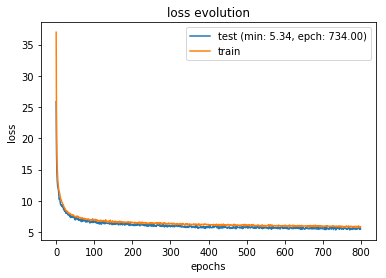

In [254]:
out_batch = NEpochLogger(x_train_data=dataset_cond_emb['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info)
model_CVAE_cond_emb.main_train(dataset_cond_emb, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[out_batch],validation_split=0.1)

In [255]:
x_input = dataset_cond_emb['train']['x']
emb_inputs=x_input[1:]
emb_outputs = model_CVAE_cond_emb.embedding_enc.predict(emb_inputs)

input_encoder = [dataset['train']['x'][0], emb_outputs]


x_encoded = model_CVAE_cond_emb.encoder.predict(input_encoder)[0]
x_hat = model_CVAE_cond_emb.cvae.predict(x=dataset_cond_emb['train']['x'])[0]


In [264]:
model_eval

{'informativeness': array([0.30554123, 0.55347017, 0.96862526, 0.67148965, 0.56823934,
        0.5446764 ]),
 'disentanglement': array([0.04174116, 0.00921201, 0.01742047, 0.02433333]),
 'compactness': array([0.00182864, 0.02541669, 0.25775555, 0.01340463, 0.02555496,
        0.05771813]),
 'mean_disentanglement': 0.02317674343850304,
 'mig': 0.12159674685722129}

In [263]:
model_eval, importanceMatrix =evaluateLatentCode(x_encoded, factorMatrix, factorDesc)
print('mean_absolute_error : ',np.mean(np.sum(np.abs(dataset_cond_emb['train']['x'][0] - x_hat), axis=1)))
print('mean_squared_error : ',np.mean(np.sqrt(np.sum((dataset_cond_emb['train']['x'][0] - x_hat)**2, axis=1))))
display_metrics(x_encoded, z_dim, factorDesc)

mean_absolute_error :  3.3866871069822193
mean_squared_error :  0.5945713303998328


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Mutual Information Gap : 0.03


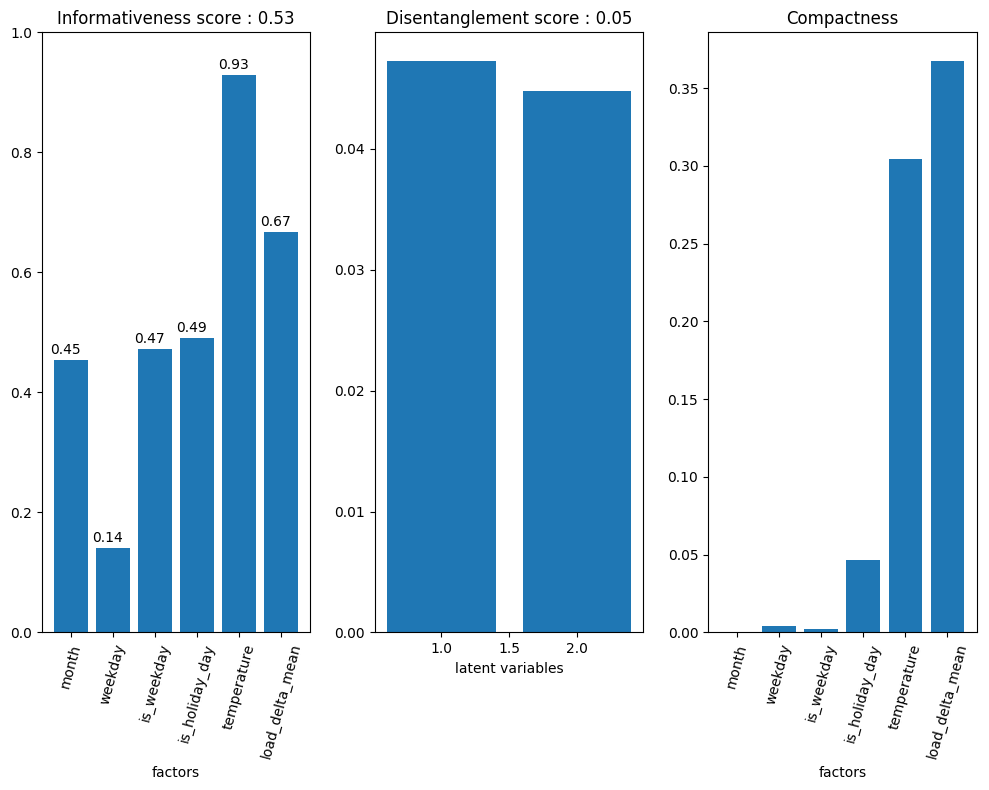

In [257]:
model_eval, importanceMatrix =evaluateLatentCode(emb_outputs, factorMatrix, factorDesc)
display_metrics(model_eval, emb_outputs.shape[1], factorDesc)